<a href="https://colab.research.google.com/github/ZoeyLLL/Risk_Factors_of_Alzheimer-s_Disease/blob/main/GAT_on_BOLD_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nodes: brain sections (ROIs)

Edges: Pearson correlation matrix thresholded (threshold |pearson| > 0.5) and keep the weight for more information in GAT

Node Features: Region-Of-Interest connectivity profile, Mean, Mean||Max


In [ ]:
import torch

from google.colab import drive
drive.mount('/content/drive')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import statistics
import scipy.stats
import networkx as nx  # Added for graph-based metrics
from sklearn.decomposition import PCA  # Added for dimensionality reduction

# Set paths
data_path = "/content/drive/MyDrive/BOLD/data/"
result_path = "/content/drive/MyDrive/BOLD/processed_data/"


# Walk through data directory and get the list of files
# Check if the directory exists and is not empty
if os.path.exists(data_path) and os.listdir(data_path):
    walk_results = list(os.walk(data_path))
    # Ensure the expected structure (root, directories, files) exists
    if walk_results and len(walk_results[0]) >= 3:
        filelist = walk_results[0][2]  # List of files in the data directory
    else:
        filelist = []  # Handle unexpected directory structure
        print(f"Warning: Unexpected structure in directory: {data_path}")
else:
    filelist = []  # Handle empty or non-existent directory
    print(f"Warning: Directory not found or empty: {data_path}")

filelist = [f for f in filelist if f != ".DS_Store"]  # Filter out unnecessary files
num_of_files = len(filelist)
print(f"Number of files: {num_of_files}")

# Define brain sections (nodes)
brain_sections = "Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,Frontal_Inf_Oper_L,Frontal_Inf_Oper_R,Frontal_Inf_Tri_L,Frontal_Inf_Tri_R,Frontal_Inf_Orb_L,Frontal_Inf_Orb_R,Rolandic_Oper_L,Rolandic_Oper_R,Supp_Motor_Area_L,Supp_Motor_Area_R,Olfactory_L,Olfactory_R,Frontal_Sup_Medial_L,Frontal_Sup_Medial_R,Frontal_Med_Orb_L,Frontal_Med_Orb_R,Rectus_L,Rectus_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Cingulum_Post_L,Cingulum_Post_R,Hippocampus_L,Hippocampus_R,ParaHippocampal_L,ParaHippocampal_R,Amygdala_L,Amygdala_R,Calcarine_L,Calcarine_R,Cuneus_L,Cuneus_R,Lingual_L,Lingual_R,Occipital_Sup_L,Occipital_Sup_R,Occipital_Mid_L,Occipital_Mid_R,Occipital_Inf_L,Occipital_Inf_R,Fusiform_L,Fusiform_R,Postcentral_L,Postcentral_R,Parietal_Sup_L,Parietal_Sup_R,Parietal_Inf_L,Parietal_Inf_R,SupraMarginal_L,SupraMarginal_R,Angular_L,Angular_R,Precuneus_L,Precuneus_R,Paracentral_Lobule_L,Paracentral_Lobule_R,Caudate_L,Caudate_R,Putamen_L,Putamen_R,Pallidum_L,Pallidum_R,Thalamus_L,Thalamus_R,Heschl_L,Heschl_R,Temporal_Sup_L,Temporal_Sup_R,Temporal_Pole_Sup_L,Temporal_Pole_Sup_R,Temporal_Mid_L,Temporal_Mid_R,Temporal_Pole_Mid_L,Temporal_Pole_Mid_R,Temporal_Inf_L,Temporal_Inf_R,Cerebelum_Crus1_L,Cerebelum_Crus1_R,Cerebelum_Crus2_L,Cerebelum_Crus2_R,Cerebelum_3_L,Cerebelum_3_R,Cerebelum_4_5_L,Cerebelum_4_5_R,Cerebelum_6_L,Cerebelum_6_R,Cerebelum_7b_L,Cerebelum_7b_R,Cerebelum_8_L,Cerebelum_8_R,Cerebelum_9_L,Cerebelum_9_R,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10"
headers = brain_sections.split(",")

# Number of ROIs (nodes)
num_of_nodes = len(headers)

# Function to calculate signal entropy
def entropy(signal):
    prob_dist = np.histogram(signal, bins=10, density=True)[0]  # Use 10 bins for example
    prob_dist = prob_dist[prob_dist > 0]  # Exclude zero values
    return -np.sum(prob_dist * np.log(prob_dist))

# Function to calculate clustering coefficient
def clustering_coefficient(corr_matrix, i):
    neighbors = np.where(corr_matrix[i, :] > 0.5)[0]
    if len(neighbors) < 2:
        return 0
    subgraph = corr_matrix[neighbors][:, neighbors]
    actual_edges = np.sum(subgraph > 0.5) / 2
    possible_edges = len(neighbors) * (len(neighbors) - 1) / 2
    return actual_edges / possible_edges if possible_edges > 0 else 0


graph_node_features = []  # Node features for each graph
graph_labels = []         # Labels for each graph
graph_edge_indices = []   # Edge indices for each graph
global_graph_features = []  # Store global graph features (e.g., mean of the whole graph)

for index, raw_file in enumerate(filelist):

    if "FACENAME" not in raw_file and "VISMOTOR" not in raw_file:
        print(f"Skipping unrelated file: {raw_file}")
        continue

    print(f"{index+1}/{num_of_files}\t{raw_file}")

    # File paths
    file = os.path.join(data_path, raw_file)
    result_file = os.path.join(result_path, raw_file)

    # Load data
    df = pd.read_csv(file)

    # Compute or load Pearson correlation matrix (weighted edges)
    if os.path.exists(result_file):
        corr = np.loadtxt(result_file, dtype='float', delimiter=',')
    else:
        # Calculate correlation matrix only if the result file doesn't exist
        corr = np.zeros((num_of_nodes, num_of_nodes))
        for i in range(num_of_nodes):
            for j in range(i+1, num_of_nodes):  # Skip redundant (j <= i) calculations
                pearson, _ = scipy.stats.pearsonr(df[headers[i]], df[headers[j]])
                if abs(pearson) >= 0.5:  # Threshold for strong correlation
                    corr[i, j] = pearson
                    corr[j, i] = pearson  # Symmetric matrix
        np.savetxt(result_file, corr, delimiter=',')  # Save the correlation matrix

    # Pre-allocate node features array
    node_features = np.zeros((num_of_nodes, 11 + num_of_nodes))

    # Compute node features (signal-based and connectivity profile)
    for i in range(num_of_nodes):
        raw_values = df[headers[i]]

        # Signal-based features (sum, max, median, mode, min, variance, standard deviation, entropy, total power)
        signal_features = [
            sum(np.abs(raw_values)),
            np.max(raw_values),
            statistics.median(raw_values),
            statistics.mode(raw_values),
            np.min(raw_values),
            np.var(raw_values),  # Variance
            np.std(raw_values),  # Standard deviation
            entropy(raw_values)  # Entropy
        ]

        # Fourier Transform (for frequency power)
        fourier_coeffs = np.fft.fft(raw_values)
        power_spectrum = np.abs(fourier_coeffs)**2
        total_power = np.sum(power_spectrum)  # Total power of the frequency spectrum

        # Add total power to the signal features
        signal_features.append(total_power)

        # Connectivity-based features
        node_degree = np.sum(corr[i, :] > 0.5)  # Node degree (connections)
        node_clustering_coefficient = clustering_coefficient(corr, i)  # Clustering coefficient

        # Combine signal and connectivity features
        node_features[i] = np.concatenate((
            signal_features,
            [node_degree, node_clustering_coefficient],
            corr[i, :]  # Connectivity profile
        ))

    # PCA on node features
    pca = PCA(n_components=10)  # Retain 10 principal components
    reduced_node_features = pca.fit_transform(node_features)  # Apply PCA on node features

    # Concatenate Mean() and Max() with node features
    mean_features = np.mean(node_features, axis=1, keepdims=True)  # Mean for each node
    max_features = np.max(node_features, axis=1, keepdims=True)  # Max for each node
    enhanced_node_features = np.hstack((node_features, mean_features, max_features))  # Mean()||Max()

    # Append the enhanced node features to graph_node_features
    graph_node_features.append(enhanced_node_features)

    # Labels for classification based on the file name
    if "FACENAME" in raw_file:
        graph_labels.append([1, 0])
    elif "VISMOTOR" in raw_file:
        graph_labels.append([0, 1])

    # Create edge index (where correlation > 0.1)
    edge = [(i, j) for i in range(num_of_nodes) for j in range(i+1, num_of_nodes) if corr[i, j] > 0.1]
    graph_edge_indices.append(edge)

    # **Global graph-level feature: Mean across all node features**
    global_mean_feature = np.mean(enhanced_node_features, axis=0)  # Mean across all nodes in the graph
    global_graph_features.append(global_mean_feature)

# Convert lists to arrays for saving
graph_node_features = np.array(graph_node_features)
graph_labels = np.array(graph_labels)
global_graph_features = np.array(global_graph_features)

# Optionally save to .npz file
np.savez_compressed('graph_data.npz',
                    graph_node_features=graph_node_features,
                    graph_labels=graph_labels,
                    global_graph_features=global_graph_features)

print(f"Loaded {len(graph_node_features)} graphs.")
print(f"Graph node features shape: {graph_node_features.shape}")
print(f"Graph labels shape: {graph_labels.shape}")
print(f"Global graph features shape: {global_graph_features.shape}")

Number of files: 4894
Skipping unrelated file: sub-HCA6102038_task-REST_dir-PA_run-2_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
Skipping unrelated file: sub-HCA7253064_task-REST_dir-AP_run-1_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
Skipping unrelated file: sub-HCA8363278_task-REST_dir-AP_run-2_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
Skipping unrelated file: sub-HCA7397391_task-REST_dir-AP_run-1_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
5/4894	sub-HCA9515684_task-VISMOTOR_dir-PA_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
Skipping unrelated file: sub-HCA6576689_task-CARIT_dir-PA_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
7/4894	sub-HCA6542470_task-FACENAME_dir-PA_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
8/4894	sub-HCA6498190_task-FACENAME_dir-PA_space-MNI152NLin2009cAsym_desc-denoised_bold_AAL_time_series.csv
Skipping unrelated 

In [ ]:
graph_labels = np.argmax(graph_labels, axis=1)  # Convert one-hot encoded labels to class indices



In [ ]:
from collections import Counter
print(Counter(graph_labels))  # This will show the number of samples in each class


Counter({0: 698, 1: 637})


In [ ]:
#Dataset Preparation

#Loaded 1335 graphs.
#Graph node features shape: (1335, 116, 129)
#Graph labels shape: (1335, 2)
#Global graph features shape: (1335, 129)

#convert to 2D tensor: (num_nodes, input_dim), where each row is the feature vector for one node.
!pip install torch_geometric
import torch
from torch_geometric.data import Data

# Ensure graph_labels is already a list of class indices, not one-hot encoded
# Assuming graph_labels is a 1D array or list like [0, 1, 0, 1, ...]

data_list = []  # List to hold PyTorch Geometric Data objects

for i in range(len(graph_labels)):
    # Convert node features to torch tensor
    node_features = torch.tensor(graph_node_features[i], dtype=torch.float)  # Node features

    # Check if edge indices exist for this graph
    if i < len(graph_edge_indices):
        edge_index = torch.tensor(graph_edge_indices[i], dtype=torch.long).t().contiguous()  # Use edge index
    else:
        print(f"Missing edge indices for graph {i}. Using dummy edge index.")
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Dummy edge index if missing

    # Create PyTorch Geometric Data object
    # Make sure to unsqueeze labels so they have the correct shape (1, ) per graph
    label = torch.tensor([graph_labels[i]], dtype=torch.long)  # Single label per graph

    # Create the data object
    data = Data(x=node_features, edge_index=edge_index, y=label)

    # Add data to the list
    data_list.append(data)

print(f"Total number of Data objects created: {len(data_list)}")

# Print first 5 labels for verification
for data in data_list[:5]:
    print(f"Label: {data.y.item()}")




Total number of Data objects created: 1335
Label: 1
Label: 0
Label: 0
Label: 1
Label: 1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes=2, hidden_dim=16):
        super(GAT, self).__init__()
        self.hid = hidden_dim
        self.num_features = num_features
        self.num_classes = num_classes

        # GAT layers
        self.conv1 = GATConv(self.num_features, self.hid, heads=1, dropout=0.6)
        self.conv2 = GATConv(self.hid, self.hid, heads=1, dropout=0.6)
        self.conv3 = GATConv(self.hid, self.hid, heads=1, dropout=0.6)
        self.conv4 = GATConv(self.hid, self.hid, heads=1, dropout=0.6)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(self.hid)
        self.bn2 = nn.BatchNorm1d(self.hid)
        self.bn3 = nn.BatchNorm1d(self.hid)

        # Fully connected layer for graph-level classification
        self.fc = nn.Linear(self.hid, self.num_classes)

    def forward(self, x, edge_index, batch):
        # GAT layer 1
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)

        # GAT layer 2
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        # GAT layer 3
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)

        # GAT layer 4
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)

        # Global mean pooling to aggregate node-level features into a graph-level representation
        x = global_mean_pool(x, batch)  # Shape becomes (batch_size, hidden_dim)

        # Pass through fully connected layer
        x = self.fc(x)  # Shape becomes (batch_size, num_classes)

        return F.log_softmax(x, dim=-1)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(num_features=129, num_classes=2, hidden_dim=16).to(device)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Batch

# Convert the data to PyTorch Geometric Data objects
data_list = []

#Store accuracies for the plotting
accuracies = []

for i in range(len(graph_labels)):
    node_features = torch.tensor(graph_node_features[i], dtype=torch.float)
    edge_index = torch.tensor(graph_edge_indices[i], dtype=torch.long).t().contiguous()  # Transpose for (2, num_edges) shape
    label = torch.tensor([graph_labels[i]], dtype=torch.long)  # Single label per graph

    # Create a Data object for each graph
    data = Data(x=node_features, edge_index=edge_index, y=label)
    data_list.append(data)

# Initialize model
model = GAT(num_features=129, num_classes=2).to(device)  # Assuming 129 input features

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
epochs = 2000
batch_size = 32  # Mini-batch size for training

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    num_samples = 0

    # Shuffle the dataset indices for mini-batch selection
    perm = torch.randperm(len(data_list))

    for i in range(0, len(data_list), batch_size):
        optimizer.zero_grad()

        # Create mini-batch
        batch_data = [data_list[j] for j in perm[i:i + batch_size]]

        # Use Batch.from_data_list to batch the graphs
        batch = Batch.from_data_list(batch_data).to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)

        # Compute loss
        loss = F.cross_entropy(out, batch.y.view(-1))  # Flatten the labels
        total_loss += loss.item() * batch.num_graphs  # Multiply by num_graphs in the batch
        num_samples += batch.num_graphs  # Track total number of graphs in epoch

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this mini-batch
        pred = out.argmax(dim=1)
        correct += (pred == batch.y.view(-1)).sum().item()

    # Step the scheduler after each epoch
    scheduler.step()

    # Print average loss and accuracy for each epoch
    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete.")


<ipython-input-66-bc13df10cda0>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(graph_node_features[i], dtype=torch.float)


Epoch 1/2000, Loss: 0.6563, Accuracy: 0.5828
Epoch 2/2000, Loss: 0.5886, Accuracy: 0.7094
Epoch 3/2000, Loss: 0.5227, Accuracy: 0.7603
Epoch 4/2000, Loss: 0.5142, Accuracy: 0.7581
Epoch 5/2000, Loss: 0.4631, Accuracy: 0.7820
Epoch 6/2000, Loss: 0.4397, Accuracy: 0.7940
Epoch 7/2000, Loss: 0.4243, Accuracy: 0.8127
Epoch 8/2000, Loss: 0.4067, Accuracy: 0.8315
Epoch 9/2000, Loss: 0.4193, Accuracy: 0.8225
Epoch 10/2000, Loss: 0.3921, Accuracy: 0.8247
Epoch 11/2000, Loss: 0.3597, Accuracy: 0.8562
Epoch 12/2000, Loss: 0.2957, Accuracy: 0.8772
Epoch 13/2000, Loss: 0.2730, Accuracy: 0.8929
Epoch 14/2000, Loss: 0.2504, Accuracy: 0.9071
Epoch 15/2000, Loss: 0.2490, Accuracy: 0.9094
Epoch 16/2000, Loss: 0.2389, Accuracy: 0.9116
Epoch 17/2000, Loss: 0.2393, Accuracy: 0.9109
Epoch 18/2000, Loss: 0.2446, Accuracy: 0.9064
Epoch 19/2000, Loss: 0.2248, Accuracy: 0.9243
Epoch 20/2000, Loss: 0.2243, Accuracy: 0.9154
Epoch 21/2000, Loss: 0.2371, Accuracy: 0.9139
Epoch 22/2000, Loss: 0.2281, Accuracy: 0.91

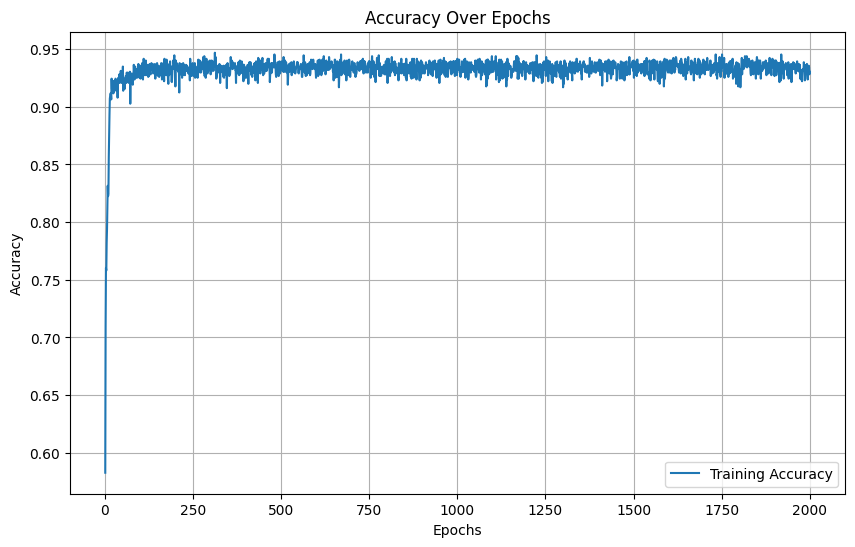

In [ ]:
epochs = 2000

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()